In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
from LRBv21 import LRBv21
from AnalyticCoolingCurves import *
from unpackConfigurationsMK import *
from refineGrid import refineGrid
from Morph import Profile, Morph

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *
# import general.plotstyle

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read balance file

In [2]:
file_paths = {
    "V10" : r"C:\Users\mikek\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\mikek\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
    #  "SPR38" : r"C:\Users\mikek\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc",
     "SPR45" : r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
     }


eqb = dict()
machines = list(file_paths.keys())

for machine in machines:
    eqb[machine] = dict()

    for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
        eqb[machine][side] = unpackConfigurationMK(File = file_paths[machine], Type = side, sepadd=3, resolution = 2000)
        
        keys = list(eqb[machine][side].keys())
        for key in keys:
            
            if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
                eqb[machine][side].pop(key, None)
        
    
# file_write(eqb, "equilibrium.pkl")

In [3]:
%matplotlib inline
plt.close("all")

In [1]:
fig, ax = plt.subplots()

for machine in machines:
    p = eqb[machine]["il"]    
    
    x = p["Spol"][-1] - p["S"]
    
    ax.plot(x, p["Bpol"], label = machine)
    
ax.legend()

NameError: name 'plt' is not defined

## Set up settings

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1.5e9, # heat flux density at the x point
    "nu0" : 0.4e20, # Upstream density (if constant)
    "cz0" : 0.1, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbach("Ar"), # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}


constants = constants_default.copy() # Set settings to default
radios = radios_default.copy() # Set settings to default


## Set up stores dict

In [5]:
allstores = {}

In [46]:
cvar = "power"

cz0s_il = dict(
    V10 = 0.027, 
    V10X = 0.021, 
    SPR38 = 0.0175, 
    SPR45 = 0.01)


cz0s_ol = dict(
    V10 = 0.05, 
    V10X = 0.042, 
    SPR38 = 0.03, 
    SPR45 = 0.02)

for machine in machines:
    print(machine)
    allstores[machine] = {}
    
    for side in ["il", "ol"]:
        print(side)
        d = eqb[machine][side]
        SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], 30) # 
        SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]
        # SparRange = [0]
        
        if "o" in side:
            constants["nu0"] = 0.62e20
            constants["cz0"] = cz0s_ol[machine]
        else:
            constants["nu0"] = 0.8e20
            constants["cz0"] = cz0s_il[machine]
            

        try: 
            results = LRBv21(constants, radios, d, 
                SparRange, 
                verbosity = 0, control_variable = cvar, 
                Ctol = 1e-4, Ttol=1e-4,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 10,
                zero_qpllt = True)
        
        except KeyboardInterrupt:
            print("Stopped")
            sys.exit(0)
        
        allstores[machine][side] = copy.deepcopy(results)

V10
il
Solving...0.00...0.16...0.31...0.48...0.64...0.82...1.02...1.19...1.40...1.59...1.81...2.01...2.26...2.52...2.75...3.04...3.30...3.62...3.93...4.30...4.70...5.08...5.56...6.09...6.64...7.28...8.17...9.09...10.24...11.45...Complete in 133.2 seconds
ol
Solving...0.00...0.21...0.43...0.67...0.93...1.20...1.48...1.79...2.10...2.44...2.78...3.16...3.53...3.91...4.30...4.69...5.10...5.51...5.96...6.40...6.87...7.36...7.89...8.47...9.12...9.91...10.84...12.02...13.72...16.58...Complete in 129.3 seconds
V10X
il
Solving...0.00...0.51...1.11...1.71...2.34...2.99...3.72...4.39...5.06...5.79...6.44...7.08...7.72...8.41...9.05...9.69...10.40...11.07...11.76...12.48...13.31...14.12...15.07...16.03...17.14...18.48...20.11...22.24...24.35...26.34...Complete in 147.8 seconds
ol
Solving...0.00...0.21...0.44...0.69...0.95...1.22...1.52...1.84...2.16...2.50...2.86...3.24...3.61...4.00...4.39...4.81...5.22...5.65...6.08...6.55...7.03...7.54...8.10...8.73...9.44...10.27...11.32...12.92...15.26...19.5

In [144]:
write_file(allstores, "2024-03-15 - compare V10 V10X SPR38 SPR45.pkl")

2024-03-15 - compare V10 V10X SPR38 SPR45.pkl written


In [5]:
allstores = read_file("2024-03-15 - compare V10 V10X SPR38 SPR45.pkl")

2024-03-15 - compare V10 V10X SPR38 SPR45.pkl loaded


In [66]:
for machine in machines:
    print(f"{machine}: {allstores[machine]['ol']['cvar'][0]:.2e}")    

V10: 2.28e+09
V10X: 2.29e+09
SPR38: 2.26e+09
SPR45: 2.30e+09


# Plot overall config

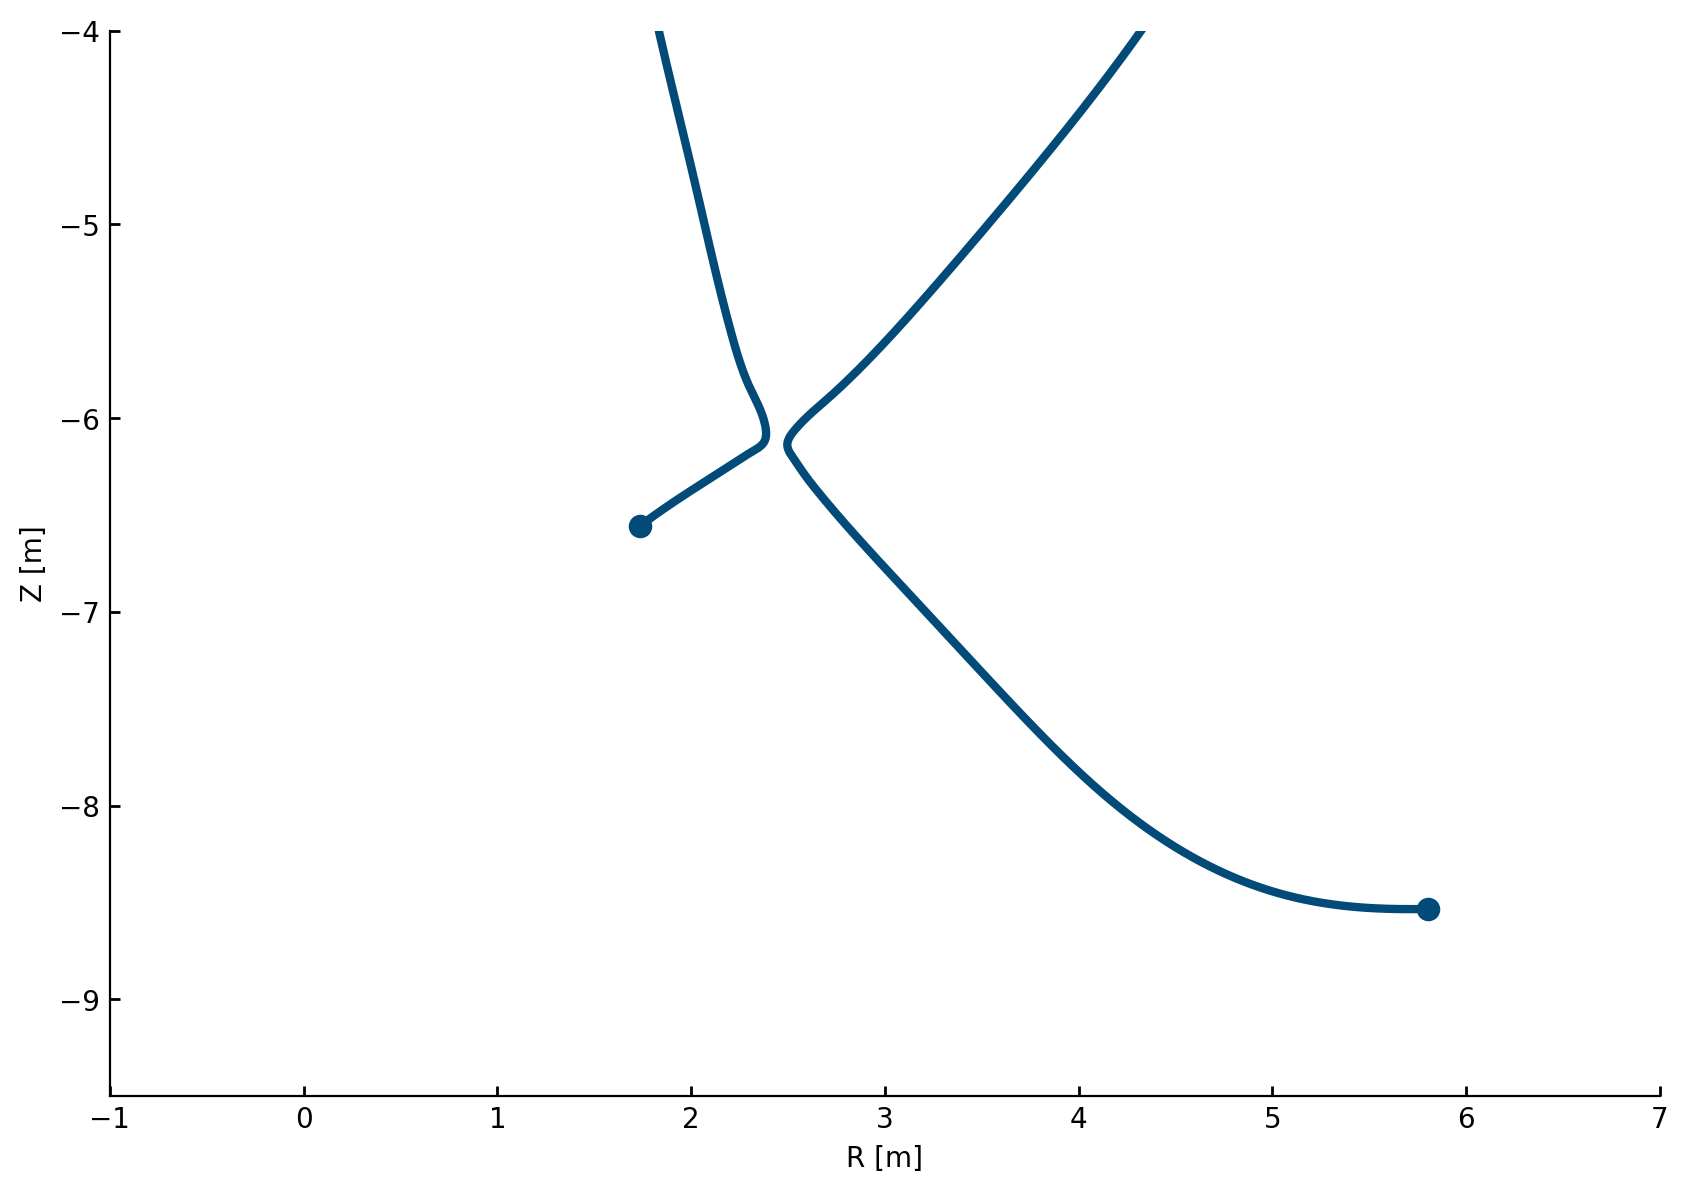

In [143]:
fig, ax = plt.subplots(dpi = 200, figsize = (10,7))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

for i, machine in enumerate(["SPR45"]):
    inner = eqb[machine]["il"]
    outer = eqb[machine]["ol"]
    
    for side in [inner, outer]:
        ax.plot(side["R"], side["Z"], color = "#024B79", lw = 3, alpha = 1, label = machine)
        
        ax.scatter(side["R"][0], side["Z"][0], color = "#024B79", s = 30, marker = "o", linewidths = 3)
    
ax.set_aspect("equal")   
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")
# ax.legend(loc = "upper left", bbox_to_anchor = (1,0.9))
ax.set_ylim(-9.5, -4)
ax.set_xlim(-1,7)
ax.grid(visible=False)

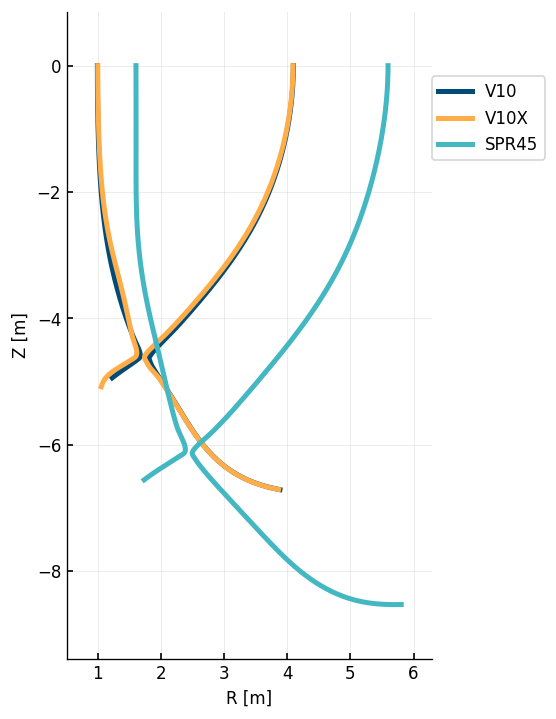

In [191]:
fig, ax = plt.subplots(figsize = (10,7))

colors = colors = ["#024B79", "#FFAD48", "#43B7C2"]

for i, machine in enumerate(machines):
    inner = eqb[machine]["il"]
    outer = eqb[machine]["ol"]
    
    ax.plot(inner["R"], inner["Z"], color = colors[i], lw = 3, alpha = 1, label = machine)
    ax.plot(outer["R"], outer["Z"], color = colors[i], lw = 3, alpha = 1)
    
ax.set_aspect("equal")   
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")
ax.legend(loc = "upper left", bbox_to_anchor = (1,0.9))

## Plot profiles

### Just V10X

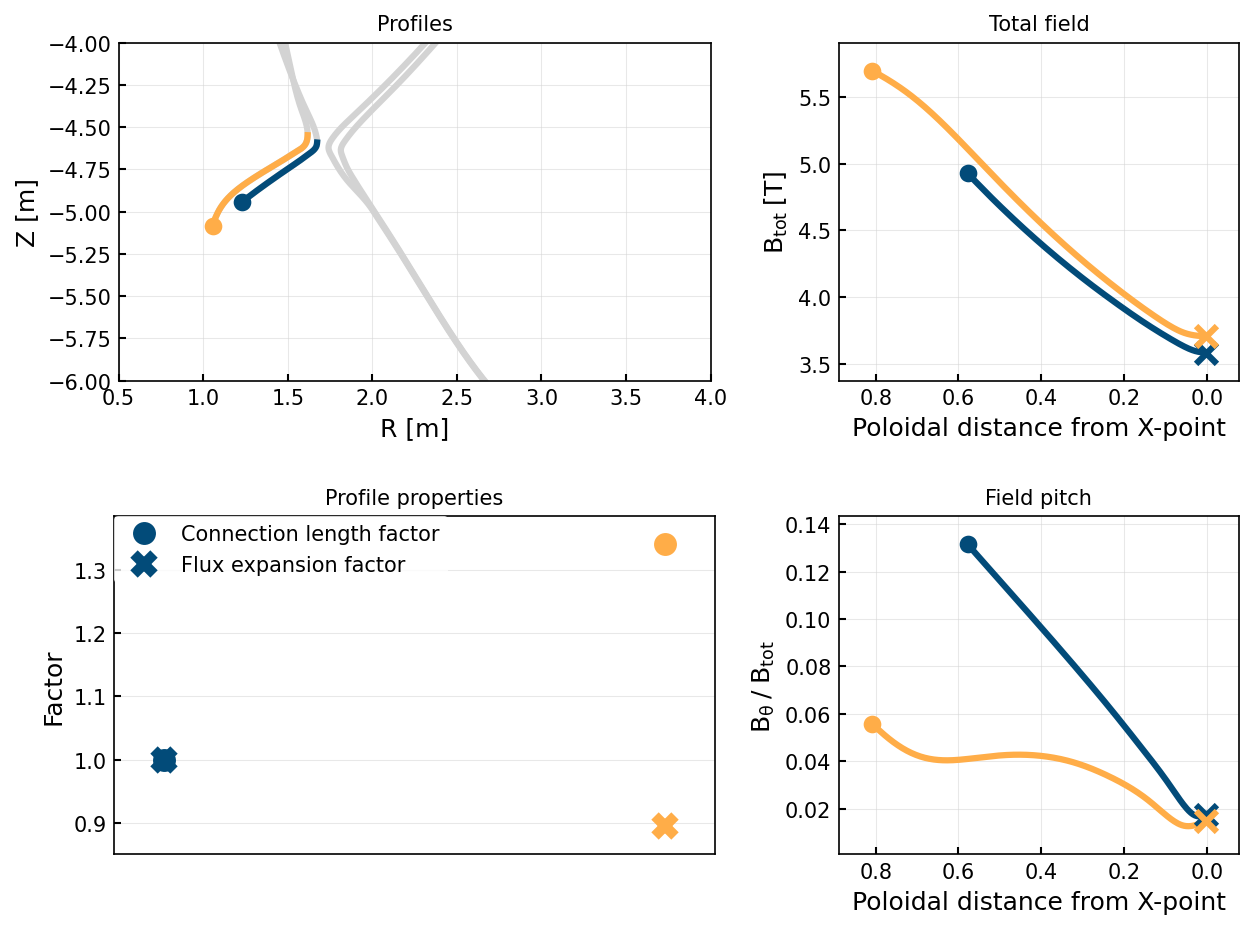

In [7]:
profiles_ol = {}
profiles_il = {}

for machine in ["V10", "V10X"]:
    d = eqb[machine]["ol"]
    profiles_ol[machine] = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
    
    d = eqb[machine]["il"]
    profiles_il[machine] = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
    
xlims = (0.5,4)
ylims = (-6,-4)
plot_all = False
colors = ["#024B79", "#FFAD48"]
plotter = {}
# plotter["outer"] = plotProfiles(profiles_ol, basis = "Spol", side = "outer", colors = colors)
# plotter["outer"].gridplot(["Btot", "Btotgrad"], [eqb["V10"], eqb["V10X"]], designs_ylims = ylims, designs_xlims = xlims, plot_all = plot_all)

plotter["inner"] = plotProfiles(profiles_il, basis = "Spol", side = "inner", colors = colors)
plotter["inner"].gridplot(["Btot", "Bpitch"], [eqb["V10"], eqb["V10X"]], designs_ylims = ylims, designs_xlims = xlims, plot_all = plot_all)

In [184]:
profiles_ol.keys()

dict_keys(['V10', 'V10X', 'SPR45'])

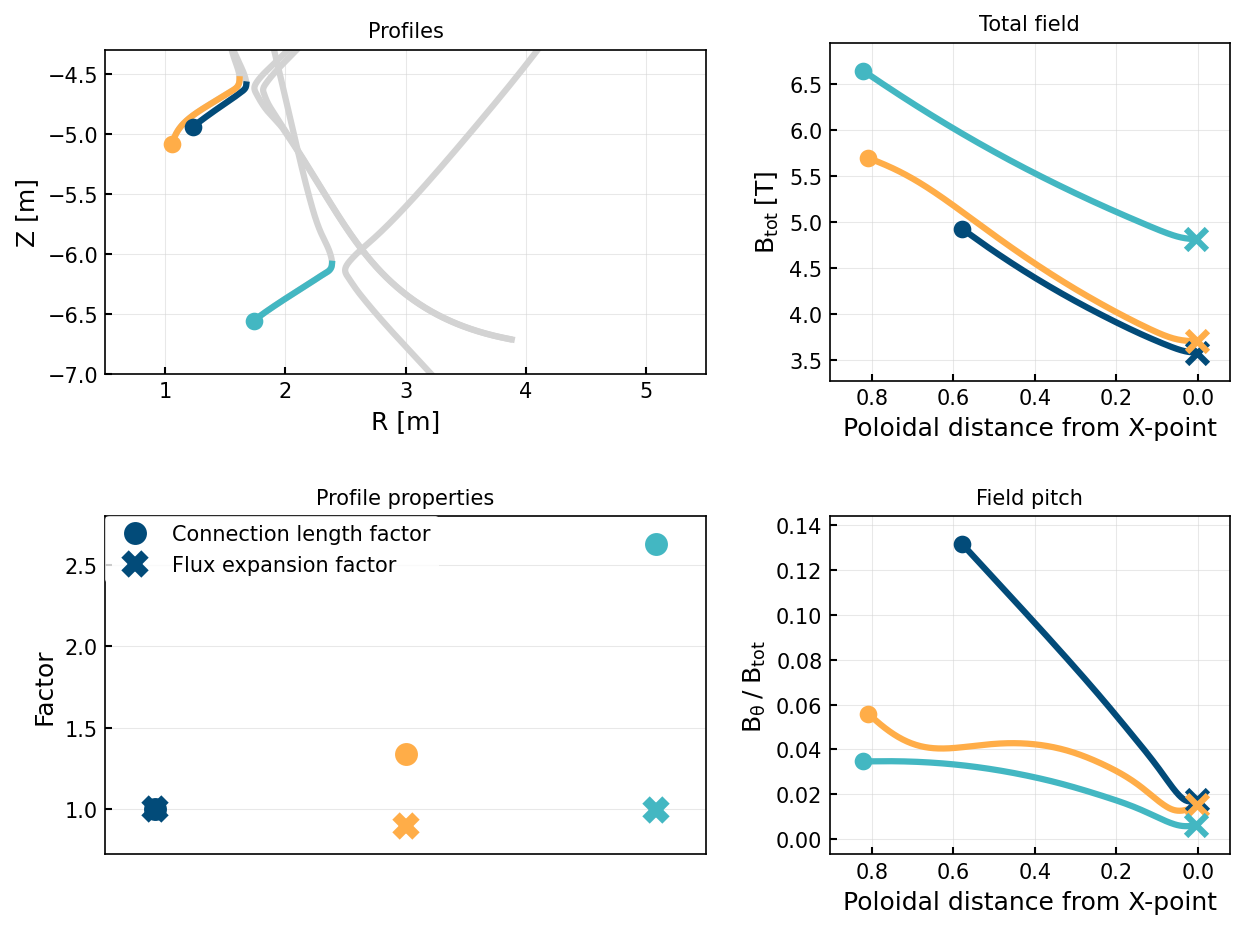

In [9]:
profiles_ol = {}
profiles_il = {}

for machine in machines:
    d = eqb[machine]["ol"]
    profiles_ol[machine] = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
    
    d = eqb[machine]["il"]
    profiles_il[machine] = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
    
xlims = (0.5,9.5)
ylims = (-9,-4)
plot_all = False
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ["#024B79", "#FFAD48", "#43B7C2"]

plotter = {}
# plotter["outer"] = plotProfiles(profiles_ol, basis = "Spol", side = "outer", colors = colors)
# plotter["outer"].gridplot(["Btot", "Btotgrad"], [eqb["V10"], eqb["V10X"], eqb["SPR45"]], designs_ylims = ylims, designs_xlims = xlims, plot_all = plot_all)

xlims = (0.5, 5.5)
ylims = (-7,-4.3)
plotter["inner"] = plotProfiles(profiles_il, basis = "Spol", side = "inner", colors = colors)
plotter["inner"].gridplot(["Btot", "Bpitch"], [eqb["V10"], eqb["V10X"], eqb["SPR45"]], designs_ylims = ylims, designs_xlims = xlims, plot_all = plot_all)

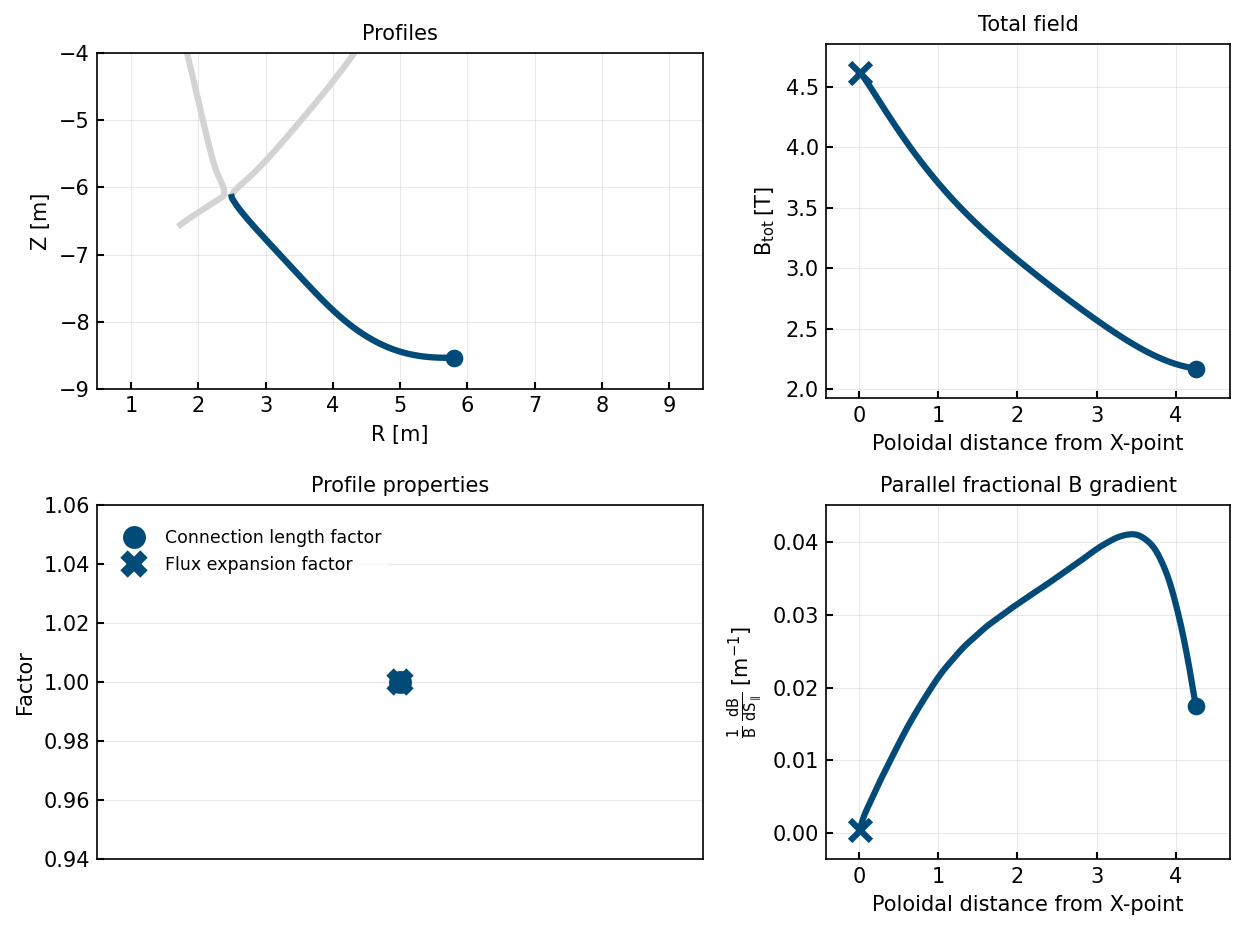

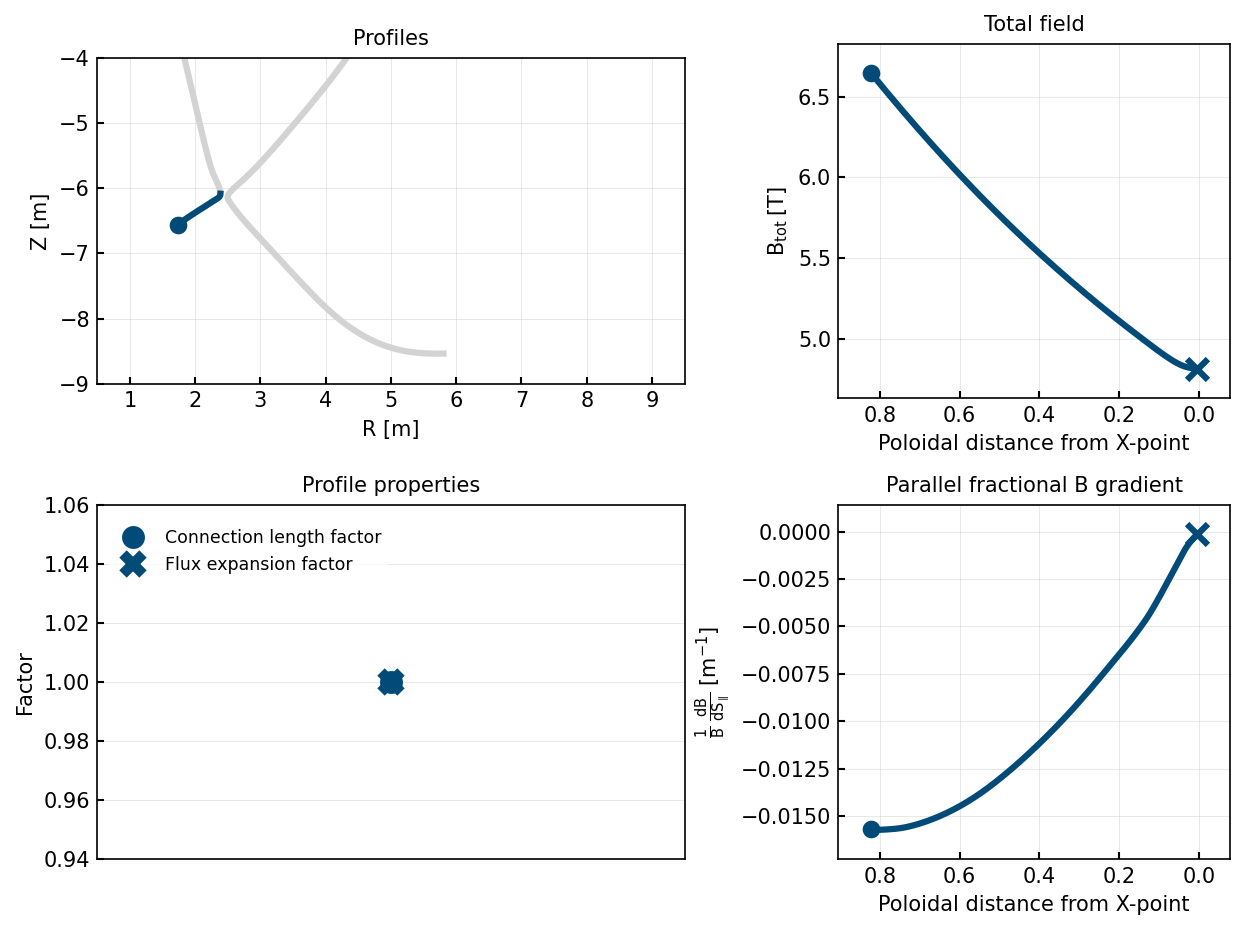

In [133]:
profiles_ol = {}
profiles_il = {}

for machine in ["SPR45"]:
    d = eqb[machine]["ol"]
    profiles_ol[machine] = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
    
    d = eqb[machine]["il"]
    profiles_il[machine] = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
    
xlims = (0.5,9.5)
ylims = (-9,-4)
plot_all = False
colors = ["#024B79"]

plotter = {}
plotter["outer"] = plotProfiles(profiles_ol, basis = "Spol", side = "outer", colors = colors)
plotter["outer"].gridplot(["Btot", "Btotgrad"], [eqb["SPR45"]], designs_ylims = ylims, designs_xlims = xlims, plot_all = plot_all)

plotter["inner"] = plotProfiles(profiles_il, basis = "Spol", side = "inner", colors = colors)
plotter["inner"].gridplot(["Btot", "Btotgrad"], [eqb["SPR45"]], designs_ylims = ylims, designs_xlims = xlims, plot_all = plot_all)

# Postprocess results

## Compose stores

In [11]:
stores_il = {}
stores_ol = {}
for machine in machines:
    stores_il[machine] = allstores[machine]["il"]
    stores_ol[machine] = allstores[machine]["ol"]

## Beff

In [71]:
stores_ol["SPR45"].keys()

dict_keys(['Splot', 'SpolPlot', 'cvar', 'Sprofiles', 'Tprofiles', 'Rprofiles', 'Qprofiles', 'Spolprofiles', 'Btotprofiles', 'Bpolprofiles', 'Xpoints', 'Wradials', 'logs', 'spar_onset', 'spol_onset', 'splot', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_frac', 'window_ratio', 'constants', 'radios', 'state'])

In [117]:
(4.8/5.8)/(4.8/6.6)

1.1379310344827587

Text(0, 0.5, 'Total B field [T]')

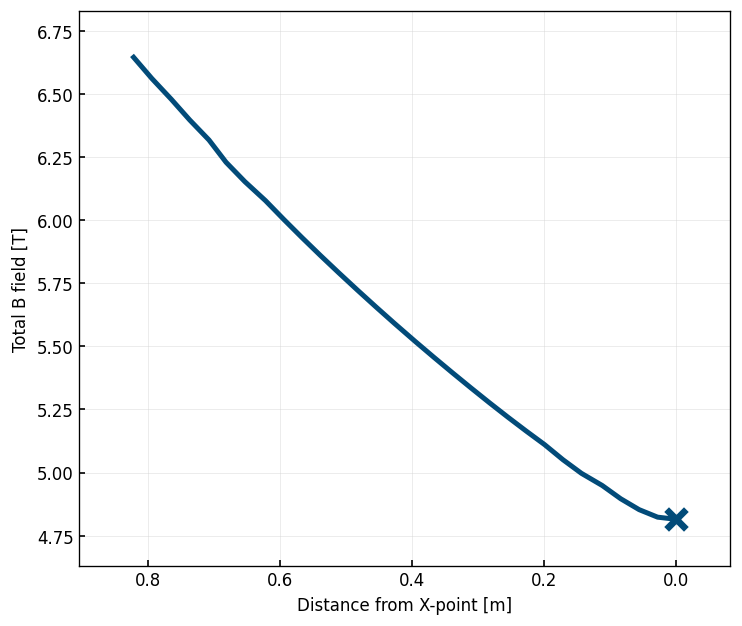

In [22]:

mode = "inner"

if mode == "outer":
    df = get_front_widths(profiles_ol["SPR45"], stores_ol["SPR45"])
    x = df["Spol"]
elif mode == "inner":
    df = get_front_widths(profiles_il["SPR45"], stores_il["SPR45"])
    x = df["Spol"][::-1]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(figsize = (7,6))
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)


colors = ['#024B79', '#FFAD48']

ax.plot(x, df["Btot"], label = "Thin front assumption", lw = 3, color = colors[0])
# ax.plot(x, df["Btot_eff"], label = "DLS-Extended", lw = 3, color = colors[1])


# for i, y in enumerate(["Btot", "Btot_eff"]):
for i, y in enumerate(["Btot"]):
    ax.scatter(x.iloc[-1], df[y].iloc[-1], marker = "x", s = 140, linewidths = 4, zorder = 50, color = colors[i])
    # ax.scatter(x.iloc[0], df[y].iloc[0], marker = "o", s = 60, linewidths = 2, zorder = 50, color = colors[i])
if mode == "inner": ax.set_xlim(ax.get_xlim()[::-1])


ax.set_xlabel("Distance from X-point [m]")
ax.set_ylabel("Total B field [T]")

# leg = ax.legend(loc = "upper right", bbox_to_anchor = (1, 0.95))
# leg.get_frame().set_linewidth(0)


In [68]:
profiles_ol["SPR45"]

In [155]:
data = dict(
                Btot = {"y" : lambda x: x.Btot, "ylabel" : r"$B_{tot}\ [T]$"},
                Bpol = {"y" : lambda x: x.Bpol, "ylabel" : r"$B_{\theta}\ [T]$"},
                Btotgrad = {"y" : lambda x: (np.gradient(x.Btot, x.S)/x.Btot), "ylabel" : r"$\frac{1}{B} \frac{dB}{dS_{\parallel}}\ [T]$"},
                Bpitch = {"y" : lambda x: (x.Bpol/x.Btot), "ylabel" : r"$B_{tot} \/ B_{\theta}$"}
            )

In [11]:
outers = plotProfiles(profiles_ol, basis = "Spol", side = "outer")
inners = plotProfiles(profiles_il, basis = "Spol", side = "inner")

# self.plot_Lc_BxBt()
outers.plot_field(mode = "Btot")
inners.plot_field(mode = "Btot")

NameError: name 'profiles_ol' is not defined

## Front movement profiles

## Only V10, V10x

In [179]:
print("Threshold/window improvements")
thresh=[]
for key in stores_v10:
    s = stores_v10[key]
    val = s["cvar_trim"][~np.isnan(s["cvar_trim"])][0]
    print(val)
    thresh.append(val)
    
improvement = 1/(thresh[-1] / thresh[0])

print(f"{improvement:.2f}")

Threshold/window improvements
710029468.394816
644424391.7381561
1.10


In [182]:
1.12*1.11

1.2432000000000003

In [178]:
stores_v10.keys()

dict_keys(['V10', 'V10X'])

In [173]:
np.nanargfirst(s["cvar_trim"])

AttributeError: module 'numpy' has no attribute 'nanargfirst'

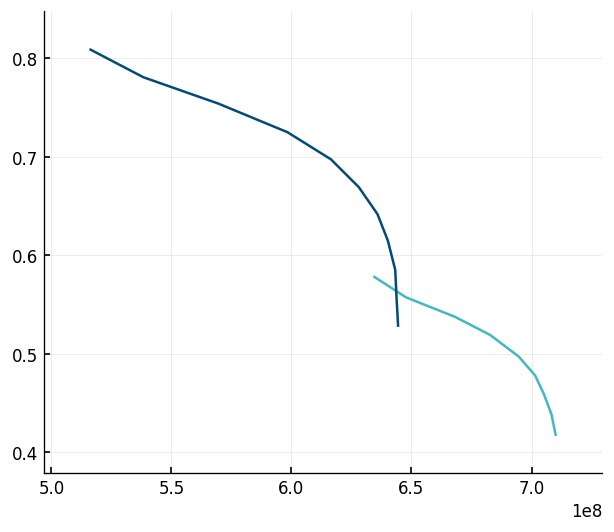

In [176]:
fig, ax = plt.subplots()
ax.plot(stores_v10["V10"]["cvar_trim"], stores_v10["V10"]["SpolPlot"])
ax.plot(stores_v10["V10X"]["cvar_trim"], stores_v10["V10X"]["SpolPlot"])

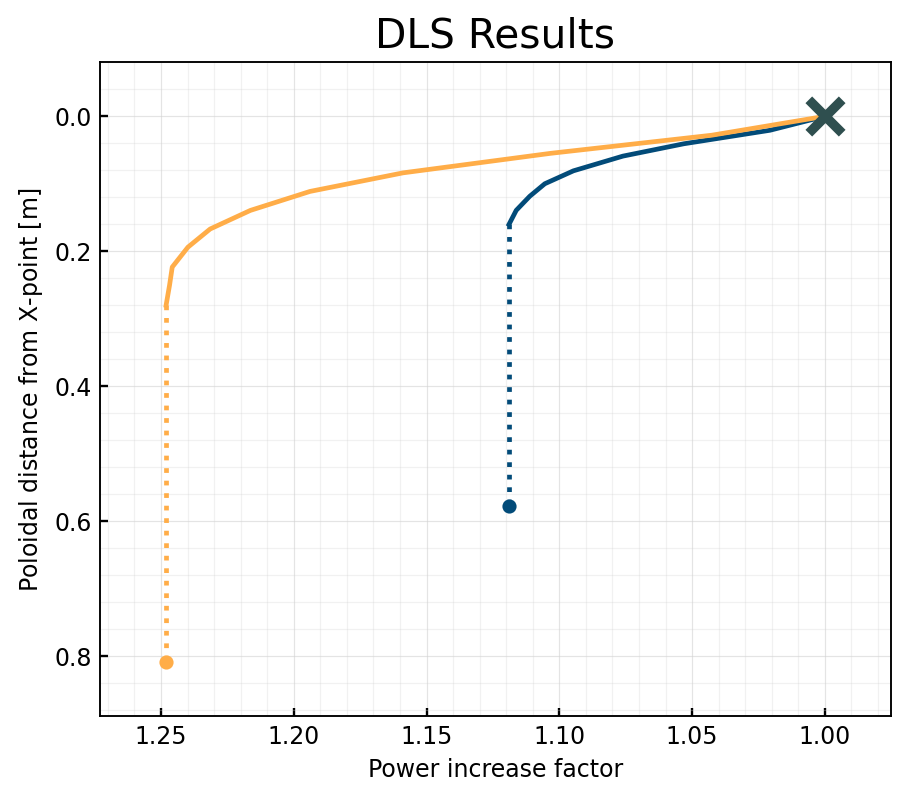

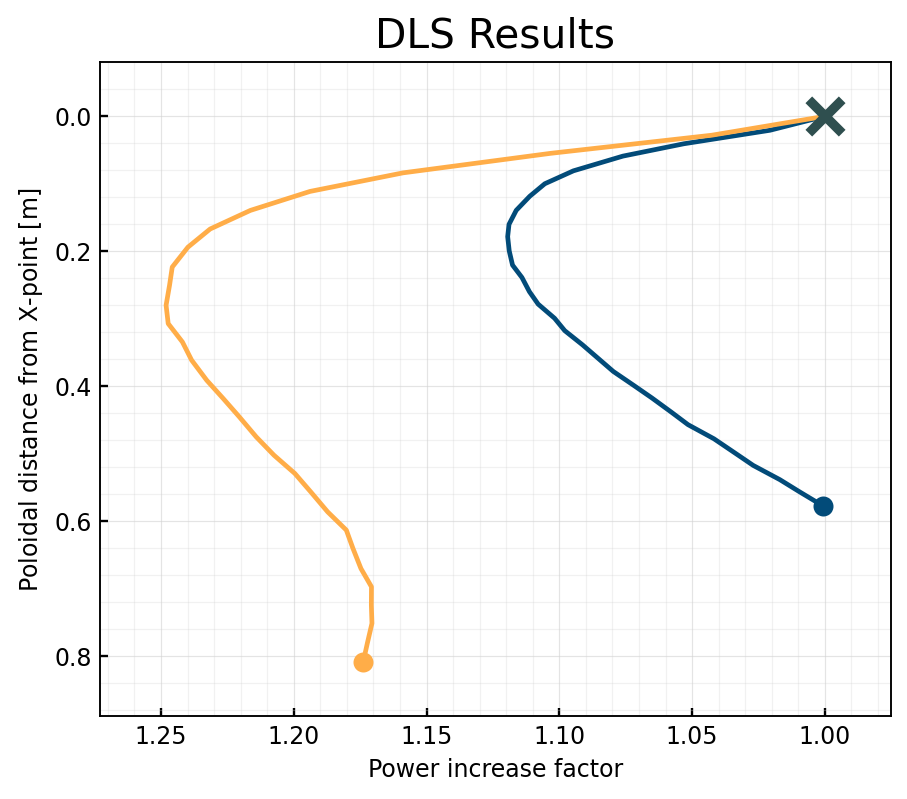

In [164]:
# plot_results(stores_ol,   mode = "outer", title = "DLS Results")

stores_v10 = dict(V10 = stores_il["V10"], V10X = stores_il["V10X"])
colors = ['#024B79', '#FFAD48']

plot_results(stores_v10,   mode = "inner", title = "DLS Results", colors = colors)
plot_results(stores_v10,   mode = "inner", title = "DLS Results", dot_unstable = False, colors = colors)

c:\Users\mikek\OneDrive\Project\python-packages\sdtools\DLS\postprocess.py:814: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


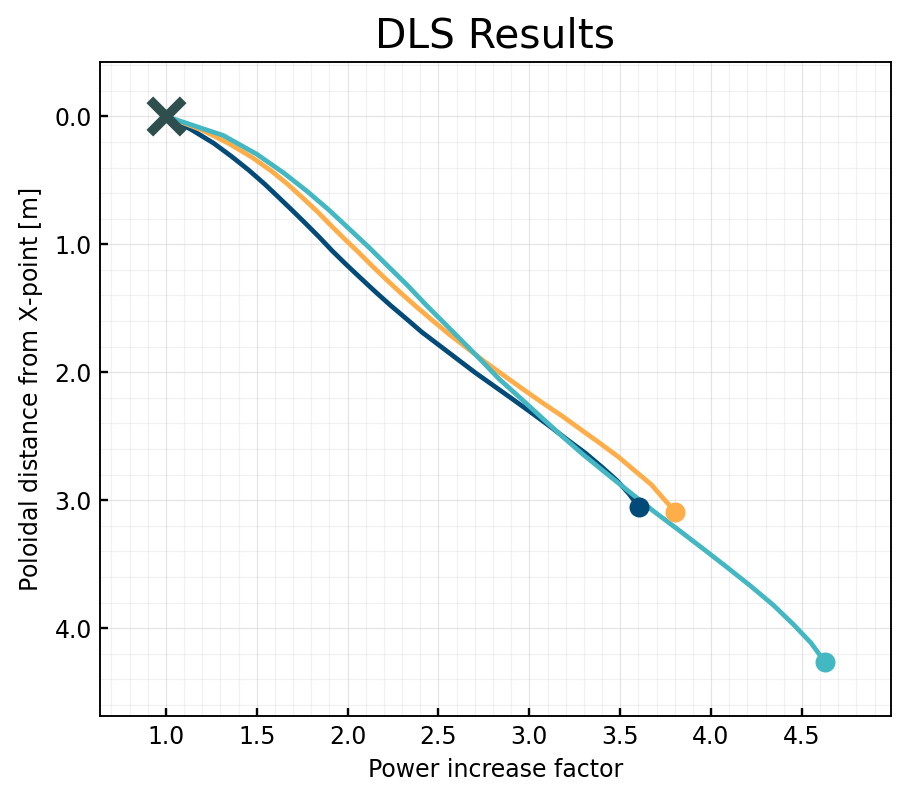

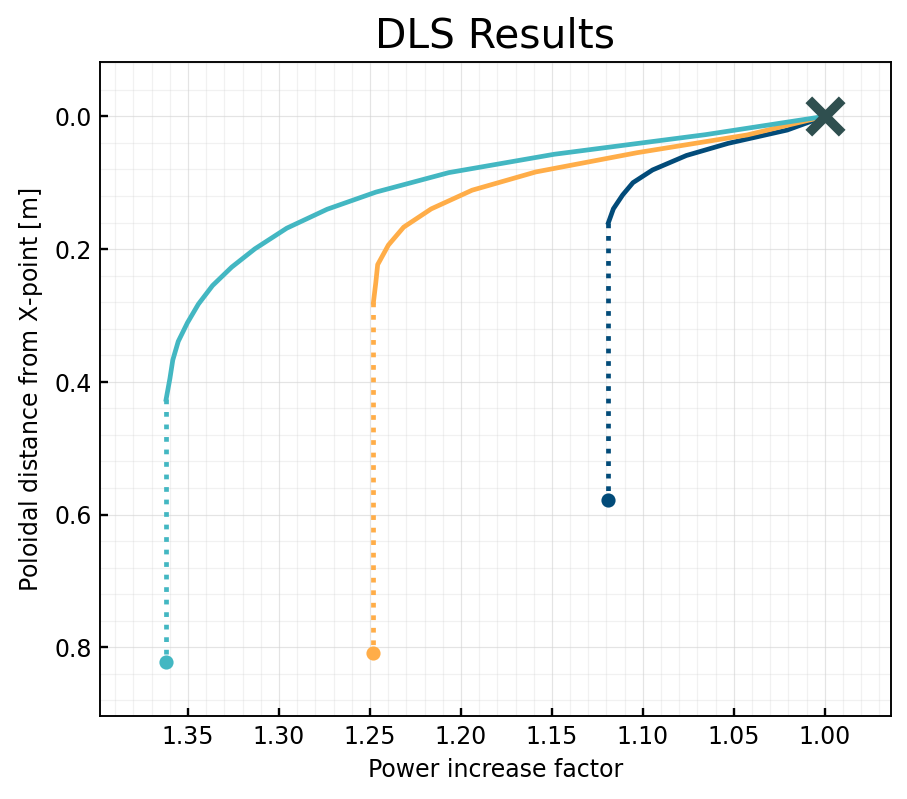

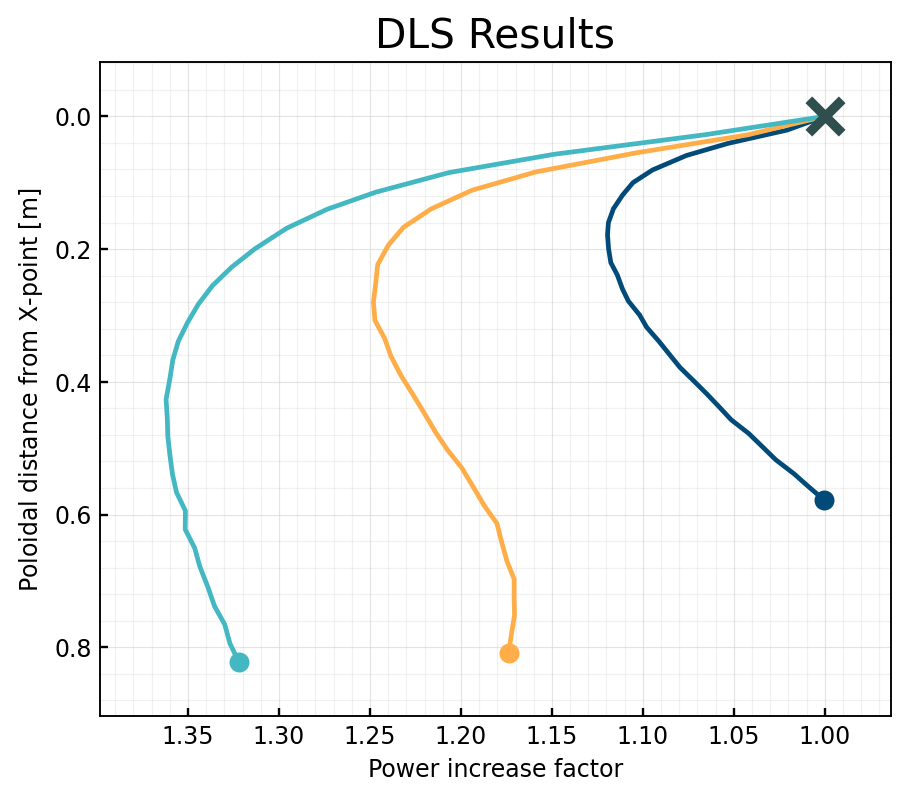

In [187]:
colors = ["#024B79", "#FFAD48", "#43B7C2"]

plot_results(stores_ol,   mode = "outer", title = "DLS Results", colors = colors)
plot_results(stores_il,   mode = "inner", title = "DLS Results", colors = colors)
plot_results(stores_il,   mode = "inner", title = "DLS Results", dot_unstable = False, colors = colors)

C:\Users\mikek\AppData\Local\Temp\ipykernel_37492\2082303195.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis', 5)
c:\Users\mikek\OneDrive\Project\python-packages\sdtools\DLS\postprocess.py:814: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


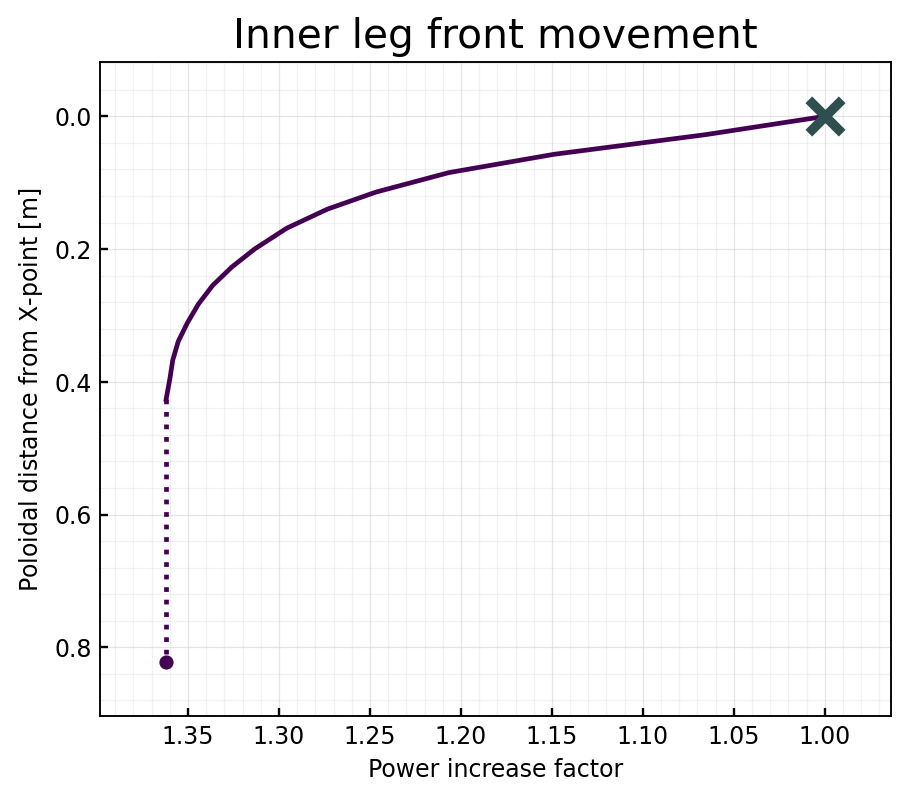

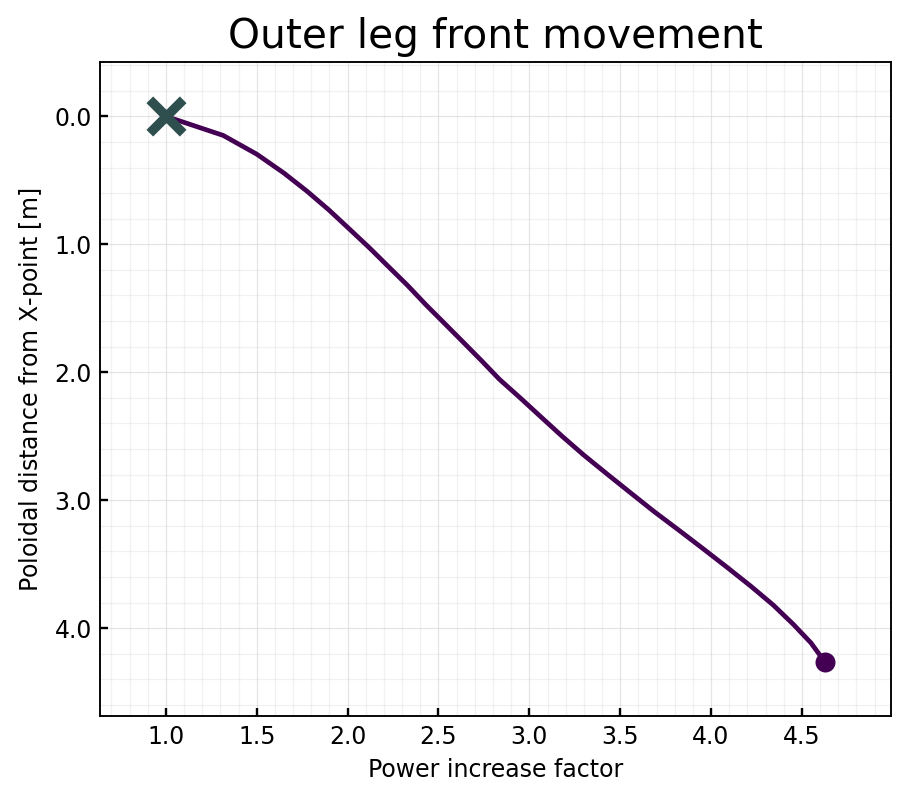

In [156]:
# for key in allstores:
#     stores = allstores[key]

cmap = mpl.cm.get_cmap('viridis', 5)
colors = [cmap(x) for x in np.linspace(0,1, 5)]

plot_results(dict(base = allstores["SPR45"]["il"]),  colors = colors, mode = "inner", title = "Inner leg front movement")
plot_results(dict(base = allstores["SPR45"]["ol"]),  colors = colors, mode = "outer", title = "Outer leg front movement")

Text(0.5, 1.0, 'Front movement: inner')

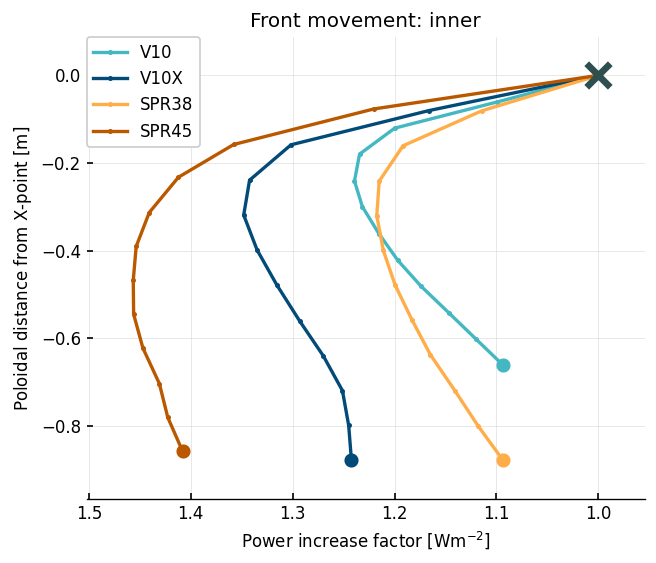

In [125]:
stores_ol = {}
stores_il = {}
for machine in machines:
    stores_ol[machine] = allstores[machine]["ol"]
    stores_il[machine] = allstores[machine]["il"]
    

stores = stores_il
mode = "inner"

# stores = stores_ol
# mode = "outer"

hide_unstable = False

fig, ax = plt.subplots()
style = dict(lw = 2, ms = 2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, key in enumerate(stores.keys()):
    s = stores[key]
    
    trim = s["cvar_trim"] / s["cvar_trim"][-1]
    if hide_unstable is True:
        x = trim
    else:
        x = s["cvar"] / s["cvar"][-1]
        
    # x = s[f"{cchoice}_trim"]
    y = s["SpolPlot"] - s["SpolPlot"][-1]
    ax.plot(x, y, label = key, color = colors[i], **style, marker = "o")
    
    if i == 0: ax.scatter(x[-1], y[-1], color = "darkslategrey", marker = "x", linewidths = 4, s = 200, zorder = 10)
    ax.scatter(x[0], y[0], color = colors[i], marker = "o", linewidths = 4, s = 20, zorder = 10)
    
    if hide_unstable is True:
        if np.isnan(trim).any():
            
            pointx = trim[~np.isnan(trim)][0]
            ax.plot([pointx, pointx], [y[np.where(trim == pointx)[0][0]], y.min()], color = colors[i], linestyle = ":", linewidth = 2)
    
# ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
# ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
# ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))

ax.grid(which = "major", visible = True,   alpha = 0.6)
ax.grid(which = "minor", visible = True,  alpha = 0.3)
if mode == "inner": ax.set_xlim(ax.get_xlim()[::-1])
ax.legend()
ax.set_xlabel("Power increase factor $[Wm^{-2}]$")
ax.set_ylabel("Poloidal distance from X-point $[m]$")
ax.set_title(f"Front movement: {mode}")
# store2.keys()